# **Boston Housing Data** - *PySpark's MLlib library for Machine Learning*


### **1. Running PySpark in Google CoLab.**

To create the required setup for running PySpark:
- **Install Java**: Install Java Development Kit (JDK) version 8, which is required for running Apache Spark
- **Install Spark:** Download (`!wget -q`) and extract (`tar xf`) Apache Spark version 3.0.0 with Hadoop version 3.2
- **Set Environment Variables:** To make Spark work correctly, you need to set the JAVA_HOME and SPARK_HOME environment variables. JAVA_HOME is set to the path where Java was installed in the previous step, and SPARK_HOME is set to the path where Spark was extracted.
- **Install findspark:** '`findspark`' is a Python library that helps locate a Spark installation and makes it easier to work with Spark in a Jupyter notebook or Python script.

In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

### **Initialize a Spark Session using PySpark**

The SparkSession is the entry point to any Spark functionality in PySpark.

Here we create a Spark session named ***'spark'***.

The `master("local[*]")` argument specifies that you want to run Spark in local mode, using all available CPU cores ("*").

`appName("BostonHousing")` sets the application name to "BostonHousing". The application name in Apache Spark is a useful metadata attribute that helps in identifying, monitoring, and managing Spark applications, especially in multi-application and cluster environments. It contributes to better organization, debugging, and resource allocation for your Spark jobs.

`getOrCreate() `method either creates a new Spark session or retrieves an existing one if it already exists in our Python environment. This is useful to ensure that we don't create multiple Spark sessions in the same application.

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BostonHousing").master("local[*]").getOrCreate()

In [3]:
# Check the version of Apache Spark that we have initialized in our PySpark session
spark.version

'3.0.0'

### **Access the underlying SparkContext**

A SparkContext is the entry point for Spark functionality in applications, and it represents the connection to a Spark cluster.

In the code above we created a SparkSession with the desired application name "BostonHousing"and master configuration.

Here we access the SparkContext using `spark.sparkContext` and assign it to the variable 'sc'.

In [4]:
# Access the underlying SparkContext
from pyspark import SparkContext

sc = spark.sparkContext
print("Application name assigned to the SparkContext 'sc': ",sc.appName,"\n")

# To get the information about the SparkContext object in PySpark
print("Info about sparkContext: ", spark.sparkContext,"\n")

# To get the Spark application name
print("Spark App Name : "+ spark.sparkContext.appName)

Application name assigned to the SparkContext 'sc':  BostonHousing 

Info about sparkContext:  <SparkContext master=local[*] appName=BostonHousing> 

Spark App Name : BostonHousing


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

### **2. Read the given CSV file**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load Boston Housing dataset
df = spark.read.csv("/content/drive/MyDrive/Data/BostonHousing.csv",header=True, inferSchema= True)

### **A glimpse of the dataset**

In [8]:
# A glimpse of the dataset
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



### **3. Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')**

In [9]:
from pyspark.ml.feature import VectorAssembler

# List of input feature columns (excluding the target column 'medv')
input_cols = [col for col in df.columns if col != 'medv']

# Initialize the VectorAssembler
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Use the assembler to transform the DataFrame
assembled_df = assembler.transform(df)

# Show the resulting DataFrame with the 'features' column
assembled_df.select("features", "medv").show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



### **4. Standardize features for principal component analysis**

In [10]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

# Specify the input and output columns for the StandardScaler
input_col = "features"  # Assuming you've already created the 'features' column
output_col = "scaled_features"  # You can choose any name for the output column

# Initialize the StandardScaler
scaler = StandardScaler(inputCol=input_col, outputCol=output_col, withStd=True, withMean=True)

# Fit the scaler on the DataFrame to compute the statistics
scaler_model = scaler.fit(assembled_df)

# Transform the DataFrame to add the standardized features
scaled_df = scaler_model.transform(assembled_df)

# Show the resulting DataFrame with the standardized features
scaled_df.select("features", "scaled_features", "medv").show()

+--------------------+--------------------+----+
|            features|     scaled_features|medv|
+--------------------+--------------------+----+
|[0.00632,18.0,2.3...|[-0.4193669292132...|24.0|
|[0.02731,0.0,7.07...|[-0.4169266699640...|21.6|
|[0.02729,0.0,7.07...|[-0.4169289951277...|34.7|
|[0.03237,0.0,2.18...|[-0.4163384035610...|33.4|
|[0.06905,0.0,2.18...|[-0.4120740534296...|36.2|
|[0.02985,0.0,2.18...|[-0.4166313741807...|28.7|
|[0.08829,12.5,7.8...|[-0.4098372459997...|22.9|
|[0.14455,12.5,7.8...|[-0.4032965606564...|27.1|
|[0.21124,12.5,7.8...|[-0.3955433024705...|16.5|
|[0.17004,12.5,7.8...|[-0.4003331395864...|18.9|
|[0.22489,12.5,7.8...|[-0.3939563782803...|15.0|
|[0.11747,12.5,7.8...|[-0.4064448322365...|18.9|
|[0.09378,12.5,7.8...|[-0.4091989885782...|21.7|
|[0.62976,0.0,8.14...|[-0.3468869279616...|20.4|
|[0.63796,0.0,8.14...|[-0.3459336108657...|18.2|
|[0.62739,0.0,8.14...|[-0.3471624598539...|19.9|
|[1.05393,0.0,8.14...|[-0.2975736947220...|23.1|
|[0.7842,0.0,8.14,..

### **5. Train model for two principal component analysis**

In [11]:
from pyspark.ml.feature import PCA

# Define the number of principal components (in this case, 2)
num_components = 2

# Initialize the PCA model
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")

# Fit the PCA model to the standardized data
pca_model = pca.fit(scaled_df)

# Transform the data to obtain the two principal components
pca_result = pca_model.transform(scaled_df)

# Show the resulting DataFrame with the PCA features
pca_result.select("features", "scaled_features", "pca_features", "medv").show()

+--------------------+--------------------+--------------------+----+
|            features|     scaled_features|        pca_features|medv|
+--------------------+--------------------+--------------------+----+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|24.0|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|21.6|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|34.7|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|33.4|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|36.2|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|28.7|
|[0.08829,12.5,7.8...|[-0.4098372459997...|[1.35753765586535...|22.9|
|[0.14455,12.5,7.8...|[-0.4032965606564...|[0.84121214171331...|27.1|
|[0.21124,12.5,7.8...|[-0.3955433024705...|[0.17975039564828...|16.5|
|[0.17004,12.5,7.8...|[-0.4003331395864...|[1.07312213803569...|18.9|
|[0.22489,12.5,7.8...|[-0.3939563782803...|[0.90851245271994...|15.0|
|[0.11747,12.5,7.8..


### **6. Collect distributed data in numpy array and then convert to pandas dataframe**

In [12]:
import numpy as np
import pandas as pd

# Extract the "pca_features" column from the PySpark DataFrame and collect it as a list of NumPy arrays
pca_features = pca_result.select("pca_features").rdd.map(lambda x: x[0]).collect()

# Convert the list of NumPy arrays into a single NumPy array
pca_array = np.array(pca_features)

# Convert the NumPy array to a Pandas DataFrame
pca_df = pd.DataFrame(data=pca_array, columns=[f"PC{i + 1}" for i in range(pca_array.shape[1])])

# Show the Pandas DataFrame
print(pca_df)

          PC1       PC2
0    2.096223  0.772348
1    1.455811  0.591400
2    2.072547  0.599047
3    2.608922 -0.006864
4    2.455755  0.097615
..        ...       ...
501  0.314656  0.723568
502  0.110404  0.758557
503  0.312052  1.154104
504  0.270252  1.040332
505  0.125679  0.761225

[506 rows x 2 columns]


### **7. Plot two principal components**

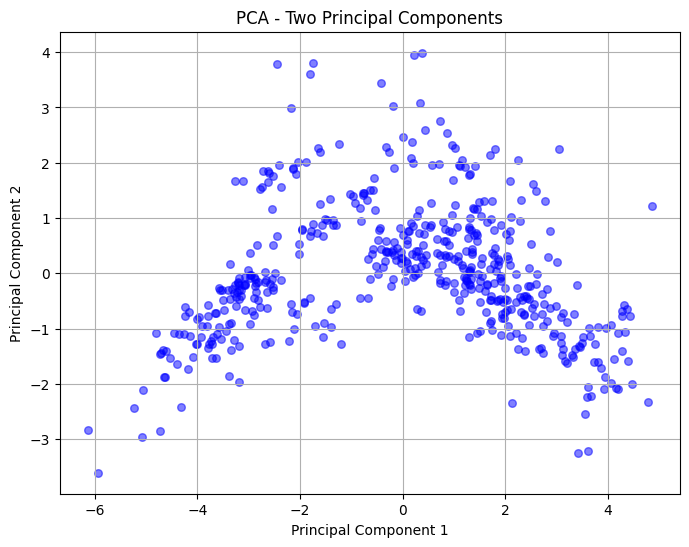

In [13]:
import matplotlib.pyplot as plt

# Extract the two principal components from the Pandas DataFrame
PC1 = pca_df["PC1"]
PC2 = pca_df["PC2"]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(PC1, PC2, marker='o', c='blue', s=30, alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - Two Principal Components")
plt.grid(True)

# Show the plot
plt.show()

### **8. Vectorize features and target together for model development**

In [14]:
from typing_extensions import Final
# Select the 'features' and 'medv' columns
selected_df = assembled_df.select("features", "medv")

# Show the resulting DataFrame
selected_df.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



### **9. Split dataset into training and testing dataset**

In [15]:
# Split the dataset into training and testing sets (e.g., 80% for training and 20% for testing)
train_ratio = 0.8
test_ratio = 0.2

# Use the randomSplit method to create the training and testing DataFrames
train_data, test_data = selected_df.randomSplit([train_ratio, test_ratio], seed=7)

# Show the sizes of the training and testing sets
print("\n Training set size:", train_data.count())
print("\n Testing set size:", test_data.count())


 Training set size: 398

 Testing set size: 108



### **10. Fit model for linear regression**

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="medv")

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the train data
predictions_train = lr_model.transform(train_data)

### **11. Find out model coefficients and intercept**

In [ ]:
# Get the coefficients and intercept of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print("\n Model Coefficients:", [round(coeff, 4) for coeff in coefficients])
print("\n Model Intercept:", round(intercept, 4))


 Model Coefficients: [-0.1017, 0.0544, 0.0324, 2.414, -17.9384, 3.4315, 0.0207, -1.3033, 0.3033, -0.0116, -0.9033, 0.0088, -0.6027]

 Model Intercept: 36.6913


### **12. Evaluate model for test dataset**

In [17]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using a regression evaluator:

# Root Mean Squared Error (RMSE) - measures the average prediction error, with a lower RMSE indicating better model performance.
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("\n Root Mean Squared Error (RMSE) on the test dataset:", rmse)

# Mean Squared Error (MSE) - measures the average of the squares of the errors or residuals, which are the differences between the predicted values and the actual values (or target values)
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("\n Mean Squared Error (MSE):", mse)

# Mean Absolute Error (MAE) - measures the average absolute errors between predicted and actual values.
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("\n Mean Absolute Error (MAE):", mae)

# R-squared (R2) - measures the proportion of variance in the target variable that is predictable from the independent variables.
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("\n R-squared (R2) Score:", r2)


 Root Mean Squared Error (RMSE) on the test dataset: 4.342964077749371

 Mean Squared Error (MSE): 18.86133698062144

 Mean Absolute Error (MAE): 3.0856919216518883

 R-squared (R2) Score: 0.7723909660689845


### **13. Perform further analysis for better interpretation of model results**

In [23]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Define a Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="medv")

# Create a pipeline
pipeline = Pipeline(stages=[rf])
pipeline.write().overwrite().save("pipeline")

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

pipelineModel = Pipeline.load("pipeline")

# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 30, 40]) \
    .addGrid(rf.maxDepth, [10, 15, 20]) \
    .build()

eval = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

# Set up cross-validation
crossval = CrossValidator(estimator=pipelineModel,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=5)  # The number of folds

# Fit the model on the training data
cvModel = crossval.fit(train_data)

# Make predictions on the test data
predictions = cvModel.transform(test_data)

predictions.select("medv","prediction").show()

# Evaluate the model using a regression evaluator
rmse = evaluator.evaluate(predictions)
print("\n Root Mean Squared Error (RMSE):", rmse)

# Get the best model
bestModel = cvModel.bestModel

# Get the best parameters
bestNumTrees = bestModel.stages[-1].getNumTrees
bestMaxDepth = bestModel.stages[-1].getMaxDepth()
print("\n Best Number of Trees:", bestNumTrees)
print("\n Best Max Depth:", bestMaxDepth)

+----+------------------+
|medv|        prediction|
+----+------------------+
|18.9|20.924999999999997|
|31.6| 30.48833333333333|
|24.5| 27.12333333333333|
|50.0| 45.42666666666666|
|23.1|26.527499999999996|
|20.1|            22.545|
|24.7| 25.61958333333333|
|16.5|23.716444444444445|
|34.7| 33.20666666666667|
|21.6|22.603333333333335|
|18.5|20.067500000000003|
|22.9|24.037777777777773|
|23.5| 26.62666666666667|
|27.9|26.859999999999996|
|20.7|23.535000000000004|
|20.6| 21.79333333333334|
|30.3|33.313333333333325|
|22.6|24.174444444444443|
|11.9|21.180000000000007|
|28.2|28.535000000000004|
+----+------------------+
only showing top 20 rows


 Root Mean Squared Error (RMSE): 0.8831710409595785

 Best Number of Trees: 30

 Best Max Depth: 15


### *In this comparison of linear regression and random forest regression with hyperparameter tuning and cross-validation, it is clear that the random forest model significantly outperforms the linear regression model in terms of predictive accuracy. The Root Mean Squared Error (RMSE) on the test dataset is a widely used metric for assessing the predictive performance of regression models. A lower RMSE indicates a better-fitting model, and in this case, the random forest model achieved a remarkably lower RMSE of 0.8832 compared to the linear regression model's RMSE of 4.3430.*

In [24]:
sc.stop()

In [25]:
spark.sparkContext.stop()